In [3]:
import torch

from torch import nn
from torch.nn import functional as F
from torch import optim
from torchvision import datasets
from statistics import mean
from statistics import stdev

import dlc_practical_prologue as prologue
import matplotlib.pyplot as plt
import time

import models

%load_ext autoreload
%autoreload 2

# Get the dataset

In [4]:
train_input, train_target, train_classes, test_input, test_target, test_classes  = prologue.generate_pair_sets(1000)
train_target.unsqueeze_(1); test_target.unsqueeze_(1)
print('train_input', train_input.size(), 'train_target', train_target.size(), 'train_classes', train_classes.size())
print('test_input', test_input.size(), 'test_target', test_target.size(), 'test_classes', test_classes.size())

train_input torch.Size([1000, 2, 14, 14]) train_target torch.Size([1000, 1]) train_classes torch.Size([1000, 2])
test_input torch.Size([1000, 2, 14, 14]) test_target torch.Size([1000, 1]) test_classes torch.Size([1000, 2])


# Training functions

In [5]:
def compute_nb_errors(model, data_input, data_target,batch_size=50):
    """ Computation of the number of wrong classifications.
    
         Args:
            model:       PyTorch neural network model
            data_input:  Tensor of size N x D representing the input dataset
            data_target: Tensor of size N x 1 representing the target of the dataset
            batch_size:  Size of the batch

        Returns:
            Number of wrong classified sample.
    """
    nb_data_errors = 0
    
    for inputs, targets in zip(data_input.split(batch_size), data_target.split(batch_size)):
        output = model(inputs)
        output = output.narrow(dim=1,start=0,length=1)
        output = torch.ge(output,0.5).float()
        for k in range(len(targets)):
            if output[k] != targets[k]:
                nb_data_errors += 1
                
    return nb_data_errors

In [14]:
def train_model(model, train_input, train_target, test_input, test_target,
                train_classes=None, use_auxiliary_losses=False,
                round=0, epochs=25,eta=0.4,batch_size=100):
    """ Train function for model 1 and 2
    
         Args:
            model:                PyTorch neural network model
            train_input:          Tensor of size N x 2 x 14 x 14 representing the input dataset
            train_target:         Tensor of size N x 1 representing the target of the dataset
            test_input:           Tensor of size N x 2 x 14 x 14 representing the input dataset
            test_target:          Tensor of size N x 1 representing the target of the dataset
            train_classes:        Tensor of size N x 2 x 10 representing the class of the two handwritten digits
            use_auxiliary_losses: Boolean representing the use of the auxiliary_losses
            round:                Number of round
            epochs:               Number of epochs
            eta:                  Learning rate
            batch_size:           Size of the batch

        Returns:
            Accuracy on the test dataset.
    """
    test_accuracy = [0] * epochs
    
    # definition of the loss and optimizer
    criterion = nn.BCELoss(reduction='mean')
    auxiliary_criterion = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=eta)
    
    # normalization
    mu, std = train_input.mean(), train_input.std()
    train_input.sub_(mu).div_(std)
    test_input.sub_(mu).div_(std)
    
    
    for i in range(epochs):
        for inputs, targets, class_targets in zip(train_input.split(batch_size),
                                   train_target.split(batch_size),
                                   train_classes.split(batch_size)):
            output = model(inputs) 
 
            # Prediction of which digit is larger
            loss = criterion(output.narrow(dim=1,start=0,length=1), targets.float())
        
            # Auxiliary losses for prediciting the actual digits
            if use_auxiliary_losses:
                l_2 = auxiliary_criterion(output.narrow(dim=1,start=1,length=10),
                                      class_targets[:,0])
                l_3 = auxiliary_criterion(output.narrow(dim=1,start=11,length=10),
                                      class_targets[:,1])
                loss += l_2 + l_3
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()   
        test_accuracy[i] = compute_nb_errors(model, test_input, test_target)
        train_accuracy = compute_nb_errors(model, train_input, train_target)
        test_accuracy[i] = 100 * (1 - test_accuracy[i] / test_input.size(0))
        train_accuracy = 100 * (1 - train_accuracy / train_input.size(0))
        if (round==0):
            print(f"Epoch # {i+1} / train accuracy: {train_accuracy:.2f} / test accuracy: {test_accuracy[i]:.2f}")
        
    if (round>0):
        print(f"Round # {round} / train accuracy: {train_accuracy:.2f} / test accuracy: {test_accuracy[-1]:.2f}")

    return test_accuracy;

In [46]:
def train_model_auxiliary_loss(model, train_input, train_target, test_input, test_target, train_classes,
                               round=0, epochs=25,eta=0.4,batch_size=100):
    
    test_accuracy = [0] * epochs

    criterion = nn.BCELoss(reduction='mean')
    auxiliary_criterion = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=eta)
    
    mu, std = train_input.mean(), train_input.std()
    train_input.sub_(mu).div_(std)
    test_input.sub_(mu).div_(std)
    
    for i in range(epochs):
        # model.train(True)
        for inputs, targets, class_targets in zip(train_input.split(batch_size),
                                   train_target.split(batch_size),
                                   train_classes.split(batch_size)):
            output = model(inputs) 
            # Prediction of which digit is larger
            l_1 = criterion(output.narrow(dim=1,start=0,length=1), targets.float())
            # Auxiliary losses for prediciting the actual digits
            l_2 = auxiliary_criterion(output.narrow(dim=1,start=1,length=10),
                                      class_targets[:,0])
            l_3 = auxiliary_criterion(output.narrow(dim=1,start=11,length=10),
                                      class_targets[:,1])
            loss = l_1 + l_2 + l_3
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()   

        test_accuracy[i] = compute_nb_errors(model, test_input, test_target)
        train_accuracy = compute_nb_errors(model, train_input, train_target)
        test_accuracy[i] = 100 * (1 - test_accuracy[i] / test_input.size(0))
        train_accuracy = 100 * (1 - train_accuracy / train_input.size(0))
        if (round==0):
            print(f"Epoch # {i+1} / train accuracy: {train_accuracy:.2f} / test accuracy: {test_accuracy[i]:.2f}")
        
    if (round>0):
        print(f"Round # {round} / train accuracy: {train_accuracy:.2f} / test accuracy: {test_accuracy[-1]:.2f}")

    return test_accuracy;

# One Round Training

In [12]:
# First model, simplest one
net1 = models.Net1()
_ = train_model(net1, train_input, train_target, test_input, test_target, train_classes, epochs=10)

KeyboardInterrupt: 

In [9]:
# Second model introduces weight sharing for the convolutional layer
net2 = models.Net2()
_ = train_model(net2, train_input, train_target, test_input, test_target, train_classes, epochs=10)

Epoch # 1 / train accuracy: 55.10 / test accuracy: 52.60
Epoch # 2 / train accuracy: 55.10 / test accuracy: 52.60
Epoch # 3 / train accuracy: 55.10 / test accuracy: 52.60
Epoch # 4 / train accuracy: 68.10 / test accuracy: 65.20
Epoch # 5 / train accuracy: 67.70 / test accuracy: 64.80


KeyboardInterrupt: 

In [15]:
# Third model, we use the label of the digits as an auxiliary loss
net3 = models.Net3()
#_ = train_model_auxiliary_loss(net3, train_input, train_target, test_input, test_target, train_classes,epochs=10)
_ = train_model(net3, train_input, train_target, test_input, test_target, train_classes=train_classes,
                use_auxiliary_losses=True, epochs=10)

Epoch # 1 / train accuracy: 55.10 / test accuracy: 52.60
Epoch # 2 / train accuracy: 60.10 / test accuracy: 57.00
Epoch # 3 / train accuracy: 55.10 / test accuracy: 52.60
Epoch # 4 / train accuracy: 59.90 / test accuracy: 58.40
Epoch # 5 / train accuracy: 60.60 / test accuracy: 61.10
Epoch # 6 / train accuracy: 58.30 / test accuracy: 57.60
Epoch # 7 / train accuracy: 57.70 / test accuracy: 56.50
Epoch # 8 / train accuracy: 55.10 / test accuracy: 52.60
Epoch # 9 / train accuracy: 55.10 / test accuracy: 52.60
Epoch # 10 / train accuracy: 53.80 / test accuracy: 54.60


In [16]:
# Fourth model, we add batch normalization
net4 = models.Net4()
_ = train_model(net4, train_input, train_target, test_input, test_target, train_classes=train_classes,
                use_auxiliary_losses=True, epochs=10)

Epoch # 1 / train accuracy: 79.10 / test accuracy: 77.30
Epoch # 2 / train accuracy: 86.90 / test accuracy: 81.10
Epoch # 3 / train accuracy: 92.80 / test accuracy: 85.00
Epoch # 4 / train accuracy: 94.80 / test accuracy: 84.70
Epoch # 5 / train accuracy: 97.90 / test accuracy: 87.20
Epoch # 6 / train accuracy: 99.10 / test accuracy: 87.60
Epoch # 7 / train accuracy: 98.20 / test accuracy: 87.30
Epoch # 8 / train accuracy: 99.90 / test accuracy: 87.20
Epoch # 9 / train accuracy: 99.80 / test accuracy: 87.70
Epoch # 10 / train accuracy: 99.90 / test accuracy: 88.70


# Multiple Round Results

In [60]:
nb_round = 100
epochs_per_round = 60
test_accuracy_1 = []
test_accuracy_2 = []
test_accuracy_3 = []
test_accuracy_4 = []

print("*** Testing Model 1 ***")
for i in range(0, nb_round):
    t0 = time.perf_counter()
    net1 = models.Net1()
    test_accuracy_1.append(train_model(net1, train_input, train_target, test_input,
                                     test_target, train_classes, round=i+1,epochs=epochs_per_round))
t_tot = time.perf_counter() - t0
print(f"Mean : {mean([row[-1] for row in test_accuracy_1]):.2f} / STD : {stdev([row[-1] for row in test_accuracy_1]):.2f} / Total Time : {t_tot:.2f} / Mean Time : {t_tot/nb_round:.2f}")

print("*** Testing Model 2 ***")
for i in range(0, nb_round):
    t0 = time.perf_counter()
    net2 = models.Net2()
    test_accuracy_2.append(train_model(net2, train_input, train_target, test_input,
                                     test_target, train_classes, round=i+1,epochs=epochs_per_round))
t_tot = time.perf_counter() - t0
print(f"Mean : {mean([row[-1] for row in test_accuracy_2]):.2f} / STD : {stdev([row[-1] for row in test_accuracy_2]):.2f} / Total Time : {t_tot:.2f} / Mean Time : {t_tot/nb_round:.2f}")

print("*** Testing Model 3 ***")
for i in range(0, nb_round):
    t0 = time.perf_counter()
    net3 = models.Net3()
    test_accuracy_3.append(train_model(net3, train_input, train_target, test_input,
                                                    test_target, train_classes, use_auxiliary_losses=False,
                                                    round=i+1,epochs=epochs_per_round))
t_tot = time.perf_counter() - t0
print(f"Mean : {mean([row[-1] for row in test_accuracy_3]):.2f} / STD : {stdev([row[-1] for row in test_accuracy_3]):.2f} / Total Time : {t_tot:.2f} / Mean Time : {t_tot/nb_round:.2f}")

print("*** Testing Model 4 ***")
for i in range(0, nb_round):
    t0 = time.perf_counter()
    net4 = models.Net4()
    test_accuracy_4.append(train_model(net4, train_input, train_target, test_input,
                                                    test_target, train_classes, use_auxiliary_losses=False,
                                                    round=i+1,epochs=epochs_per_round))
t_tot = time.perf_counter() - t0
print(f"Mean : {mean([row[-1] for row in test_accuracy_4]):.2f} / STD : {stdev([row[-1] for row in test_accuracy_4]):.2f} / Total Time : {t_tot:.2f} / Mean Time : {t_tot/nb_round:.2f}")


*** Testing Model 1 ***
Round # 1 / train accuracy: 100.00 / test accuracy: 82.00
Round # 2 / train accuracy: 100.00 / test accuracy: 84.70
Round # 3 / train accuracy: 100.00 / test accuracy: 84.00
Round # 4 / train accuracy: 100.00 / test accuracy: 83.90
Round # 5 / train accuracy: 100.00 / test accuracy: 84.70
Round # 6 / train accuracy: 100.00 / test accuracy: 85.20
Round # 7 / train accuracy: 100.00 / test accuracy: 84.60
Round # 8 / train accuracy: 100.00 / test accuracy: 83.50
Round # 9 / train accuracy: 100.00 / test accuracy: 85.30
Round # 10 / train accuracy: 100.00 / test accuracy: 83.30
Round # 11 / train accuracy: 100.00 / test accuracy: 85.10
Round # 12 / train accuracy: 100.00 / test accuracy: 83.30
Round # 13 / train accuracy: 100.00 / test accuracy: 82.40
Round # 14 / train accuracy: 100.00 / test accuracy: 83.10
Round # 15 / train accuracy: 100.00 / test accuracy: 84.40
Round # 16 / train accuracy: 100.00 / test accuracy: 84.10
Round # 17 / train accuracy: 100.00 / tes

Round # 39 / train accuracy: 100.00 / test accuracy: 84.80
Round # 40 / train accuracy: 100.00 / test accuracy: 86.20
Round # 41 / train accuracy: 100.00 / test accuracy: 84.80
Round # 42 / train accuracy: 100.00 / test accuracy: 86.40
Round # 43 / train accuracy: 100.00 / test accuracy: 85.00
Round # 44 / train accuracy: 100.00 / test accuracy: 84.20
Round # 45 / train accuracy: 100.00 / test accuracy: 84.70
Round # 46 / train accuracy: 100.00 / test accuracy: 86.00
Round # 47 / train accuracy: 100.00 / test accuracy: 84.80
Round # 48 / train accuracy: 100.00 / test accuracy: 86.80
Round # 49 / train accuracy: 100.00 / test accuracy: 85.00
Round # 50 / train accuracy: 100.00 / test accuracy: 86.20
Round # 51 / train accuracy: 100.00 / test accuracy: 84.90
Round # 52 / train accuracy: 100.00 / test accuracy: 85.30
Round # 53 / train accuracy: 100.00 / test accuracy: 84.30
Round # 54 / train accuracy: 100.00 / test accuracy: 86.30
Round # 55 / train accuracy: 100.00 / test accuracy: 84.

Round # 77 / train accuracy: 100.00 / test accuracy: 89.30
Round # 78 / train accuracy: 100.00 / test accuracy: 90.30
Round # 79 / train accuracy: 100.00 / test accuracy: 89.90
Round # 80 / train accuracy: 100.00 / test accuracy: 88.70
Round # 81 / train accuracy: 100.00 / test accuracy: 91.40
Round # 82 / train accuracy: 100.00 / test accuracy: 91.40
Round # 83 / train accuracy: 99.80 / test accuracy: 91.70
Round # 84 / train accuracy: 99.90 / test accuracy: 87.50
Round # 85 / train accuracy: 99.80 / test accuracy: 89.90
Round # 86 / train accuracy: 100.00 / test accuracy: 87.80
Round # 87 / train accuracy: 100.00 / test accuracy: 88.80
Round # 88 / train accuracy: 100.00 / test accuracy: 89.10
Round # 89 / train accuracy: 100.00 / test accuracy: 91.70
Round # 90 / train accuracy: 100.00 / test accuracy: 89.40
Round # 91 / train accuracy: 95.70 / test accuracy: 85.00
Round # 92 / train accuracy: 100.00 / test accuracy: 90.60
Round # 93 / train accuracy: 96.00 / test accuracy: 86.80
Ro

# Plots

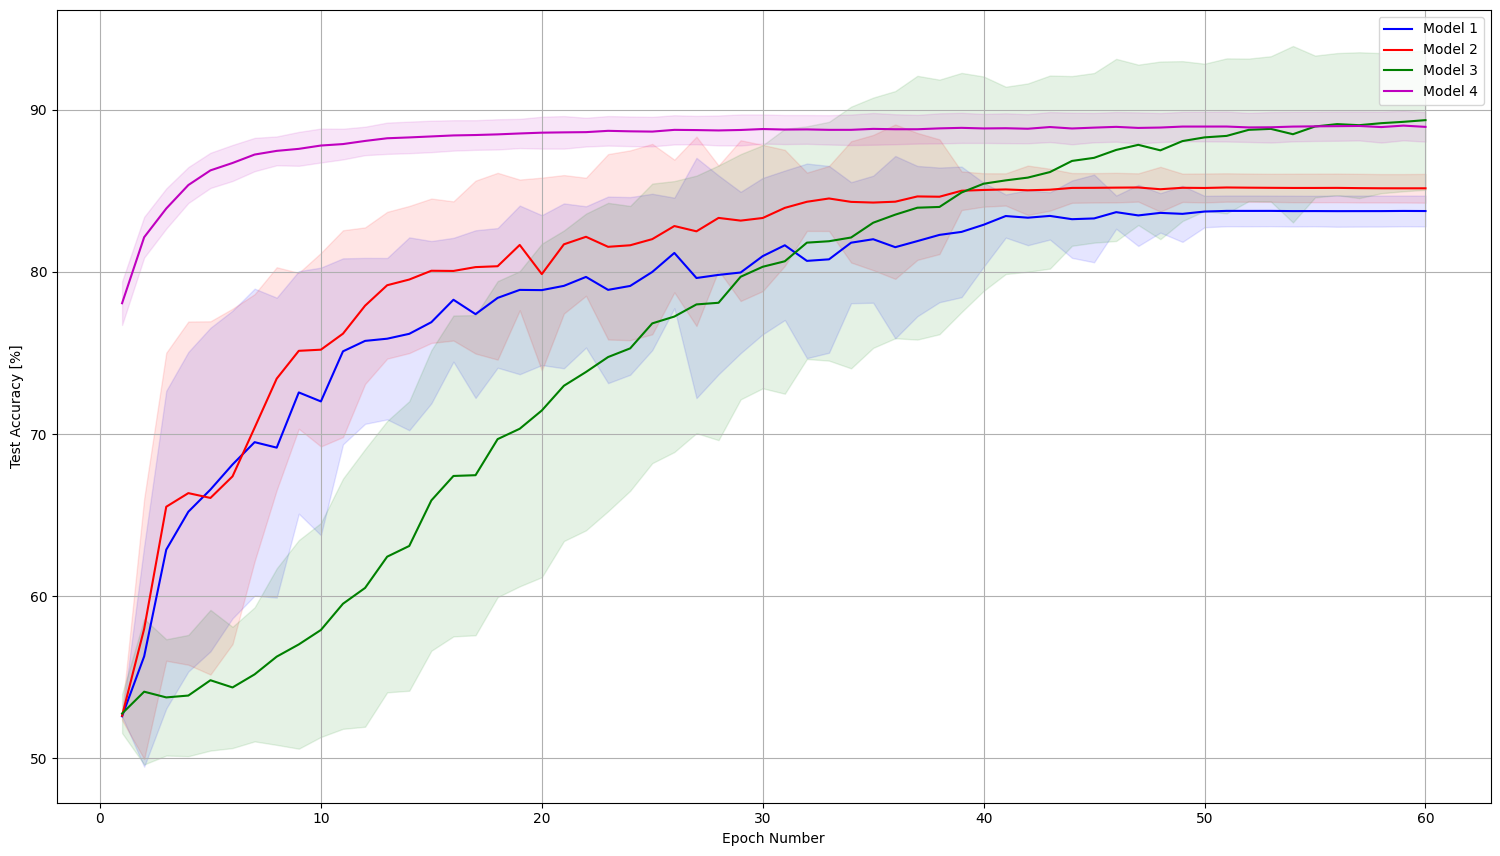

In [64]:
mean_1 = [0] * epochs_per_round
std_1 = [0] * epochs_per_round
mean_2 = [0] * epochs_per_round
std_2 = [0] * epochs_per_round
mean_3 = [0] * epochs_per_round
std_3 = [0] * epochs_per_round
mean_4 = [0] * epochs_per_round
std_4 = [0] * epochs_per_round

for i in range(epochs_per_round):
    mean_1[i] = mean([row[i] for row in test_accuracy_1])
    std_1[i] = stdev([row[i] for row in test_accuracy_1])
    mean_2[i] = mean([row[i] for row in test_accuracy_2])
    std_2[i] = stdev([row[i] for row in test_accuracy_2])
    mean_3[i] = mean([row[i] for row in test_accuracy_3])
    std_3[i] = stdev([row[i] for row in test_accuracy_3])
    mean_4[i] = mean([row[i] for row in test_accuracy_4])
    std_4[i] = stdev([row[i] for row in test_accuracy_4])

x = list(range(1,epochs_per_round+1)) 
fig, ax = plt.subplots()
plt.grid()

ax.plot(x,mean_1, color='b', label='Model 1')
ax.fill_between(x, ([x1 - x2 for (x1, x2) in zip(mean_1, std_1)]),
                ([x1 + x2 for (x1, x2) in zip(mean_1, std_1)]), color='b', alpha=.1)

ax.plot(x,mean_2, color='r', label='Model 2')
ax.fill_between(x, ([x1 - x2 for (x1, x2) in zip(mean_2, std_2)]), ([x1 + x2 for (x1, x2) in zip(mean_2, std_2)]), color='r', alpha=.1)

ax.plot(x,mean_3, color='g', label='Model 3')
ax.fill_between(x, ([x1 - x2 for (x1, x2) in zip(mean_3, std_3)]), ([x1 + x2 for (x1, x2) in zip(mean_3, std_3)]), color='g', alpha=.1)

ax.plot(x,mean_4, color='m', label='Model 4')
ax.fill_between(x, ([x1 - x2 for (x1, x2) in zip(mean_4, std_4)]), ([x1 + x2 for (x1, x2) in zip(mean_4, std_4)]), color='m', alpha=.1)

plt.xlabel('Epoch Number')
plt.ylabel('Test Accuracy [%]')
ax.legend()
fig.set_size_inches(18.5, 10.5)
fig.set_dpi(100)

# Miscellaneous

In [ ]:
res = net(test_input[0:20,0].reshape(20,1,14,14), test_input[0:20,1].reshape(20,1,14,14))
res[res>0.5] = 1
res[res <= 0.5] = 0
for i in range(0, 20):
    plt.subplot(121),plt.imshow(test_input[i, 0].view(14,14)),plt.title('Original')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(test_input[i, 1].view(14,14)),plt.title('gradient')
    plt.xticks([]), plt.yticks([])
    plt.show()
    print(res[i])

In [ ]:
res

In [ ]:
print(sum(p.numel() for p in net.parameters() if p.requires_grad))


In [ ]:
https://www.overleaf.com/6688321767qwjpzsgnrdqb